<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/DNP/OverHauserEffect.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" ></a>

# <font  color = "#0093AF"> Overhauser Effect

The Overhauser effect is the original DNP experiment, demonstrated on a conducting metal, and commonly used in solution-state DNP. However, it is also possible to obtain the Overhauser effect from non-conducting electrons such as in Trityl or BDPA. In this case, the effect comes from either modulation of the isotropic or dipolar part of the Hyperfine coupling

In [1]:
import sys
if 'google.colab' in sys.modules:
    !git clone https://github.com/alsinmr/SLEEPY.git
else:
    sys.path.append('/Users/albertsmith/Documents/GitHub.nosync/')
    sys.path.append('/Users/albertsmith/Documents/GitHub/')
import SLEEPY as sl
import numpy as np

## Example 1: Modulation of the Isotropic Hyperfine (J)

In the first example, we include a scalar and dipolar component to the coupling. However, we only modulate the scalar part. This is achieved by adding different "Aiso" to ex0 and ex1. The two Hamiltonians are then coupled together with the exchange matrix produced by `sl.Tools.twoSite_kex`, where `tc` specifies the correlation time resulting from the exchange matrix.

Increasing the change between `Aiso` and `Aiso1` will accelerate the transfer. Modifying `tc` will also change the rate, although the current value (1 ps) is nearly optimum.

<IPython.core.display.Javascript object>


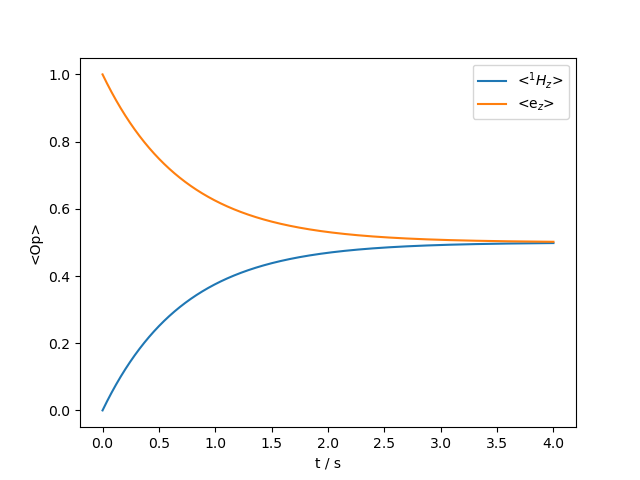

<AxesSubplot:xlabel='t / s', ylabel='<Op>'>

In [10]:
ex0=sl.ExpSys(v0H=212,Nucs=['1H','e'],LF=True,vr=5000,n_gamma=30)
ex0.set_inter('g',i=1,gxx=2.0027,gyy=2.0031,gzz=2.0034)
Adip=[-1e6,-1e6,2e6]
Aiso0=.75e6
ex0.set_inter('hyperfine',i0=0,i1=1,Axx=Adip[0]+Aiso0,Ayy=Adip[1]+Aiso0,Azz=Adip[2]+Aiso0)
ex1=ex0.copy()
Aiso1=.25e6
ex1.set_inter('hyperfine',i0=0,i1=1,Axx=Adip[0]+Aiso1,Ayy=Adip[1]+Aiso1,Azz=Adip[2]+Aiso1)

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=1e-12)

seq=L.Sequence()

rho=sl.Rho('ez',['1Hz','ez'])

rho.DetProp(seq,n=20000)

rho.plot(axis='s')

## Example 2: Reorientation of the Dipolar Hyperfine

<IPython.core.display.Javascript object>


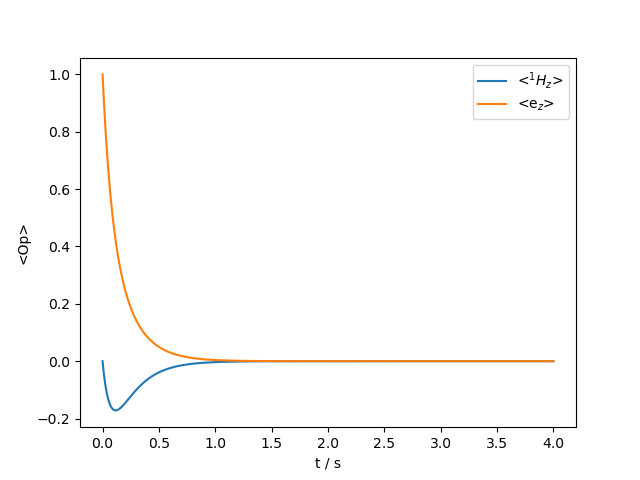

<AxesSubplot:xlabel='t / s', ylabel='<Op>'>

In [16]:
ex1.set_inter('hyperfine',i0=0,i1=1,Axx=Adip[0]+Aiso0,Ayy=Adip[1]+Aiso0,Azz=Adip[2]+Aiso0,euler=[0,np.pi/4,0])

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=1e-12)

seq=L.Sequence()

rho=sl.Rho('ez',['1Hz','ez'])

rho.DetProp(seq,n=20000)

rho.plot(axis='s')

We see sharp contrasts between the two Overhauser effect mechanisms. When the scalar coupling is modulated, the total magnetization is conserved: it is simply transferred between the electron and nucleus until the magnetization is equilibrated. On the other hand, reorientation of the dipolar component both transfers magnetization between electron and nucleus, but also gradually destroys the total magnetization. We also notice that the sign of the transfer changes. We can also simulate both mechanisms simultaneously (we reduce the size of the dipolar modulation to make the two effects occur on a similar timescale).

<IPython.core.display.Javascript object>


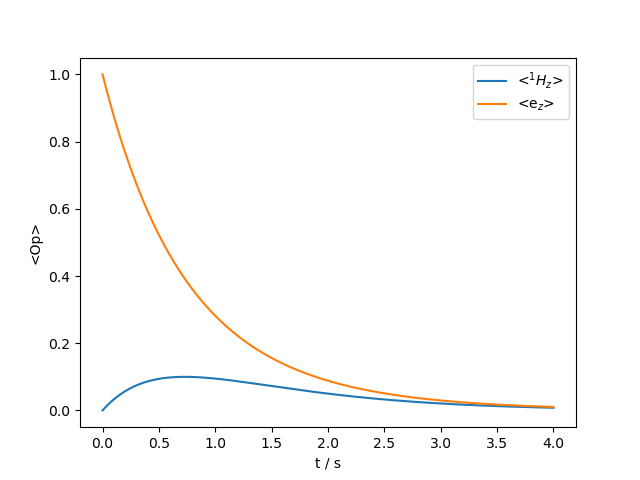

<AxesSubplot:xlabel='t / s', ylabel='<Op>'>

In [13]:
ex1.set_inter('hyperfine',i0=0,i1=1,Axx=Adip[0]+Aiso1,Ayy=Adip[1]+Aiso1,Azz=Adip[2]+Aiso1,euler=[0,np.pi/16,0])

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=1e-12)

seq=L.Sequence()

rho=sl.Rho('ez',['1Hz','ez'])
rho.DetProp(seq,n=20000)
rho.plot(axis='s')

Then, the sign of the transfer turns positive, indicating the scalar mechanism, but the dipolar mechanism is also present and gradually destroys the magnetization. Note that in the real experiment, we would have a *much* faster electron relaxation, which would effectively decouple it from the $^1$H relaxation. However, if the electron is saturated, then during it's recovery, the $^1$H would become polarized. We cannot simulate this here, because the dynamically-induced relaxation cannot be thermalized in simulation (SLEEPY does include both thermalization for explicit relaxation and saturation in the lab-frame, but this relaxation process would not be induced by an exchange process).

## Example 3: $\tau_c$-sweep for isotropic mechanism

<AxesSubplot:xlabel='t / s', ylabel='<e$_z$>'>

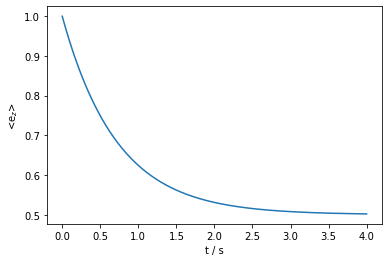

In [16]:
ex0=sl.ExpSys(v0H=212,Nucs=['1H','e'],LF=True,vr=5000,n_gamma=30)
Adip=[-1e6,-1e6,2e6]
Aiso0=.75e6
ex0.set_inter('hyperfine',i0=0,i1=1,Axx=Aiso0,Ayy=Aiso0,Azz=Aiso0)
ex1=ex0.copy()
Aiso1=.25e6
ex1.set_inter('hyperfine',i0=0,i1=1,Axx=Aiso1,Ayy=Aiso1,Azz=Aiso1)

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=1e-12)

U=L.U(1e-3)

rho=sl.Rho('ez','ez')

rho.DetProp(U,n=4000)

rho.plot(axis='s')

In [19]:
rho.extract_decay_rates(L.U(1),pwdavg=True)

State-space reduction: 32->12


1.4386831048601196e-06

In [9]:
U=L.U(1e-3).eig()

In [13]:
U._eig[0]

(array([-1.23259516e-32+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
         9.99030022e-01-3.11275871e-03j, -9.63232211e-01+2.65058719e-01j,
        -9.64310249e-01+2.62128589e-01j, -9.63330315e-01+2.68318289e-01j,
        -9.64310120e-01-2.62132011e-01j, -9.63329616e-01-2.68319827e-01j,
        -9.63230939e-01-2.65062445e-01j, -9.63230561e-01-2.65061433e-01j,
        -9.63231168e-01+2.65058512e-01j, -1.43947126e-18+3.54826972e-17j,
         9.99030319e-01-3.11277429e-03j,  9.98607847e-01-1.15777020e-09j,
         9.99030546e-01+3.11302831e-03j,  9.99030664e-01+3.11270465e-03j,
         1.00000000e+00-1.51477260e-07j,  1.00000000e+00+5.39922087e-08j,
        -2.42828829e-16+5.62002199e-18j,  1.43917213e-16+6.89100333e-17j,
         1.93053829e-16+1.20401528e-17j,  1.34331336e-16-8.36940919e-17j,
         1.63903048e-16-1.64558757e-17j, -4.18845941e-17-8.43619974e-17j,
        -9.52378472e-17+5.32109680e-17j, -2.78445788e-17+8.09507385e-17j,
        -8.70683623e-17-1.36329583e-17